# XGBoost Training and Evaluation Section

In [11]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score


def generate_dataset(movie_df, example_movies, 
                     label_movies, example_features=["Rating", "Movie_Year", "Average_Rating", "Review_Count"]):
    raw_X_list = []
    raw_Y_list = []

    example_features = ["Rating", "Movie_Year", "Average_Rating", "Review_Count"]
    num_highest = []
    
    unique_customers = movie_df['Cust_Id'].unique()

    for customer in unique_customers:
        customer_data = movie_df.loc[movie_df['Cust_Id'] == customer]

        # Ensure movies are in the same order every time
        example_data = customer_data.loc[customer_data['Name'].isin(example_movies)].copy()
        label_data = customer_data.loc[customer_data['Name'].isin(label_movies)].copy()

        example_data = example_data.sort_values(by='Name')
        label_data = label_data.sort_values(by='Name')

        # Create example matrix.. flatten it
        example_data = np.array(example_data[example_features]).flatten()

        # Identify the movie(s) with the highest rating from label_movies
        highest_rating = label_data['Rating'].max()
        highest_rated_movies = label_data[label_data['Rating'] == highest_rating]['Name'].tolist()
        num_highest.append(len(highest_rated_movies))
        
        '''
        if len(highest_rated_movies) > 9.0:
            display(label_data)
            break
        '''
        
        # Iterate through the variable number of highest rated movies.. create an example for each.
        for highest_rating_movie in highest_rated_movies:
            label_index = list(label_movies).index(highest_rating_movie)

            raw_X_list.append(example_data)
            raw_Y_list.append(label_index)
    
    # Convert lists to DataFrames
    num_example_movies = len(example_movies)
    columns = []
    for i in example_movies:
        columns.extend([f"Rating_{i}", f"Movie_Year_{i}", f"Average_Rating_{i}", f"Review_Count_{i}"])

    # Convert lists to DataFrames
    X = pd.DataFrame(raw_X_list, columns=columns)
    Y = pd.DataFrame(raw_Y_list, columns=["Movie Label"])
    
    return X, Y, columns, num_highest

def generate_test_data(movie_df, example_movies, label_movies, example_features=["Rating", "Movie_Year", "Average_Rating", "Review_Count"]):
    '''
    This method generates the data in an alternate format that will be used for the accuracy testing.
    For most examples, there are several "correct" answers.
    '''
    raw_X_list = []
    raw_Y_list = []
    num_highest = []
    
    unique_customers = movie_df['Cust_Id'].unique()

    for customer in unique_customers:
        customer_data = movie_df.loc[movie_df['Cust_Id'] == customer]

        # Filter and sort data for example and label movies
        example_data = customer_data.loc[customer_data['Name'].isin(example_movies)].copy().sort_values(by='Name')
        label_data = customer_data.loc[customer_data['Name'].isin(label_movies)].copy().sort_values(by='Name')

        # Create example matrix and flatten it
        example_data_flat = example_data[example_features].to_numpy().flatten()

        # Identify the highest rated movies from label_movies
        highest_rating = label_data['Rating'].max()
        highest_rated_movies = label_data[label_data['Rating'] == highest_rating]['Name'].tolist()
        num_highest.append(len(highest_rated_movies))
        
        # Add example data and list of correct label indices
        label_indices = [label_movies.index(movie) for movie in highest_rated_movies]
        raw_X_list.append(example_data_flat)
        raw_Y_list.append(label_indices)
    
    # Define columns for the feature DataFrame
    columns = []
    for movie in example_movies:
        columns.extend([f"{feature}_{movie}" for feature in example_features])

    # Convert lists to DataFrames
    X = pd.DataFrame(raw_X_list, columns=columns)
    #Y = pd.DataFrame(raw_Y_list, columns=["Movie Labels"])
    
    return X, raw_Y_list

def multiple_accuracy(y_true, y_pred): # y_true needs to be a list of correct labels.
    correct_predictions = 0
    total_predictions = len(y_true)
    
    for true_labels, pred in zip(y_true, y_pred):
        if pred in true_labels:
            correct_predictions += 1
    
    accuracy = correct_predictions / total_predictions
    return accuracy


def xgb_Kfold_model(X_train, Y_train):
    # Set up the hyperparameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    # Initialize the XGBoost classifier
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

    # Set up the GridSearchCV object with K-fold cross-validation
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

    # Perform the grid search and fit to the training data
    grid_search.fit(X_train, Y_train.values.ravel())

    # Retrieve the best model from the grid search
    best_model = grid_search.best_estimator_
    
    # Print the best parameters
    print("Best Parameters:", grid_search.best_params_)
    
    return best_model

## Import and Split Dataset
This section of the notebook uses the data and features generated by previous code. The input to the XGBoost model will be feature data about 10 sample movies. The output will be the highest rated movie, we will generate these labels programically.

In [2]:
data_path = "data/df_top_20_movies_customers_reviewed_all.csv"
movie_20 = pd.read_csv(data_path)
#display(movie_20.head())

unique_customers = movie_20['Cust_Id'].unique()
print("Number of Unique Customers: ", len(unique_customers))

# Remove first 100:1000 customers
test_customers = unique_customers[100:1000]
movie_train = movie_20.loc[~movie_20['Cust_Id'].isin(test_customers)]
movie_test = movie_20.loc[movie_20['Cust_Id'].isin(test_customers)]

display(movie_train.head())
display(movie_test.head())

Number of Unique Customers:  4481


,Movie_Id,Cust_Id,Rating,Date,Movie_Year,Name,Average_Rating,Review_Count
0,571,1844276,5.0,2002-03-05,1999,American Beauty,3.962585,154832
1,571,2422606,1.0,2001-11-20,1999,American Beauty,3.962585,154832
2,571,1515501,3.0,2002-11-25,1999,American Beauty,3.962585,154832
3,571,181323,4.0,2002-01-22,1999,American Beauty,3.962585,154832
4,571,243963,4.0,2002-02-26,1999,American Beauty,3.962585,154832


,Movie_Id,Cust_Id,Rating,Date,Movie_Year,Name,Average_Rating,Review_Count
100,571,2382575,4.0,2005-03-09,1999,American Beauty,3.962585,154832
101,571,1164917,2.0,2005-03-10,1999,American Beauty,3.962585,154832
102,571,1310250,5.0,2005-10-26,1999,American Beauty,3.962585,154832
103,571,425507,3.0,2005-11-28,1999,American Beauty,3.962585,154832
104,571,1962061,3.0,2005-07-10,1999,American Beauty,3.962585,154832


### Dataset generation
The code block below uses the generate_dataset() method that creates a set of examples and labels. Labels are generated by taking the movie with the maximum rating out of the label_movies list. Note, there my be several movies that have a "highest" rating. Thus, we generate an additional example, label pair for each additional "favorite" movie.

In [3]:
# Find the unique movie names
unique_movies = movie_20['Name'].unique()
#print(unique_movies)
print("Number of Unique Movies: ", len(unique_movies))

# Split data into examples and labels.
example_movies = ["American Beauty",
                 "The Wedding Planner",
                 "Man on Fire",
                 "S.W.A.T.",
                 "Pirates of the Caribbean: The Curse of the Black Pearl",
                 "50 First Dates",
                 "What Women Want",
                 "The Bourne Supremacy",
                 "Lord of the Rings: The Fellowship of the Ring",
                 "Braveheart"]
label_movies = ["The Silence of the Lambs",
               "Ghost",
               "Men in Black II",
               "The Last Samurai",
               "Bruce Almighty",
               "Shrek 2",
               "Finding Nemo (Widescreen)",
               "Patch Adams",
               "The Sixth Sense",
               "The Italian Job"]

print("Number of Example Movies: ", len(example_movies))
print("Number of Label Movies: ", len(label_movies))

X, Y, columns, num_highest = generate_dataset(movie_train, example_movies, label_movies)

Number of Unique Movies:  20
Number of Example Movies:  10
Number of Label Movies:  10


### Training Set EDA
The codeblock below implements basic data regarding dataset shape (notice how much larger the dataset is compared to the customer count.) This is due to multiple labels per example. The code block also implements a histogram to display just how often multiple labels occur! Notice how there are several customers that rate all of the movies as 5 star. In fact, it is more common to have several favorite movies rather than just one.

Example Data Shape:  (14638, 40)
Label Data Shape:  (14638, 1)


,Rating_American Beauty,Movie_Year_American Beauty,Average_Rating_American Beauty,Review_Count_American Beauty,Rating_The Wedding Planner,Movie_Year_The Wedding Planner,Average_Rating_The Wedding Planner,Review_Count_The Wedding Planner,Rating_Man on Fire,Movie_Year_Man on Fire,...,Average_Rating_The Bourne Supremacy,Review_Count_The Bourne Supremacy,Rating_Lord of the Rings: The Fellowship of the Ring,Movie_Year_Lord of the Rings: The Fellowship of the Ring,Average_Rating_Lord of the Rings: The Fellowship of the Ring,Review_Count_Lord of the Rings: The Fellowship of the Ring,Rating_Braveheart,Movie_Year_Braveheart,Average_Rating_Braveheart,Review_Count_Braveheart
0,2.0,2004.0,3.750569,145519.0,5.0,1999.0,3.962585,154832.0,5.0,1995.0,...,3.909958,137170.0,3.0,2001.0,3.183726,140154.0,5.0,2000.0,3.425322,162597.0
1,2.0,2004.0,3.750569,145519.0,5.0,1999.0,3.962585,154832.0,5.0,1995.0,...,3.909958,137170.0,3.0,2001.0,3.183726,140154.0,5.0,2000.0,3.425322,162597.0
2,2.0,2004.0,3.750569,145519.0,5.0,1999.0,3.962585,154832.0,5.0,1995.0,...,3.909958,137170.0,3.0,2001.0,3.183726,140154.0,5.0,2000.0,3.425322,162597.0
3,5.0,2004.0,3.750569,145519.0,1.0,1999.0,3.962585,154832.0,5.0,1995.0,...,3.909958,137170.0,3.0,2001.0,3.183726,140154.0,4.0,2000.0,3.425322,162597.0
4,5.0,2004.0,3.750569,145519.0,1.0,1999.0,3.962585,154832.0,5.0,1995.0,...,3.909958,137170.0,3.0,2001.0,3.183726,140154.0,4.0,2000.0,3.425322,162597.0


,Movie Label
0,5
1,0
2,8
3,3
4,8


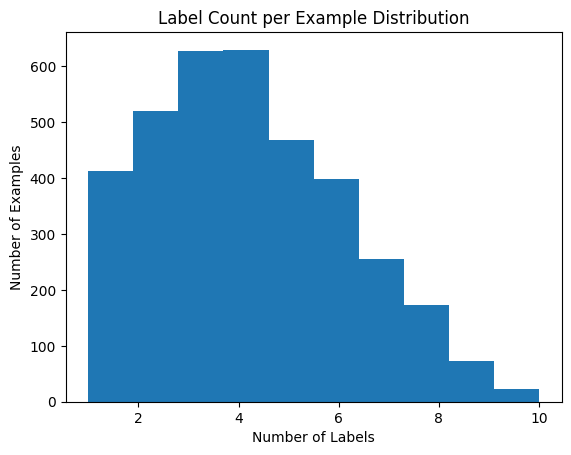

In [4]:
import matplotlib.pyplot as plt

print("Example Data Shape: ", X.shape)
print("Label Data Shape: ", Y.shape)

# Make a histogram of the number of highest rated movies
plt.hist(num_highest)
plt.title("Label Count per Example Distribution")
plt.xlabel("Number of Labels")
plt.ylabel("Number of Examples")
plt.show()

## Model Training Section
We will a standard training test split.n Note this is for training, the actual test set that will be compared to the LLM was already separated.
Also, the accuracy score here is naive, since we just assessed that multiple labels exist for almost every single example. We will implement a custom accuracy metric later in this notebook.

### Kfold Validation
Our team decided on using K-fold validation paired with GridSearchCV to find favorable hyperparameters for our XGBoost model. XGBoost is often said to overfit out of the box, so our group made sure to employ a technique that heavily invests in finding the model that generalizes best. Notice the absurdly low accuracy, this is note representative of the models true accuracy which will be evaluated on the final test set.

In [5]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Retrieve the best model from the grid search
best_model = xgb_Kfold_model(X_train, Y_train)

# Predict on the test set with the best model
Y_pred = best_model.predict(X_test)

# Evaluate the model... use a different accuracy metric
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Accuracy: 16.39%


### Feature Importance
Using XGBoost allows us to measure feature importance. The results present that additional features outside of the actual ratings of the movies themselves don't serve any purpose in classification. To improve this model, we would have to find/engineer different, more informative features.

In [6]:
# Create a DataFrame for feature importances & Display it.
feature_importances = pd.DataFrame({
    'Feature': columns,
    'Importance': best_model.feature_importances_
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
display(feature_importances)

,Feature,Importance
28,Rating_The Bourne Supremacy,0.159101
36,Rating_Braveheart,0.141086
24,Rating_What Women Want,0.138920
0,Rating_American Beauty,0.122696
32,Rating_Lord of the Rings: The Fellowship of th...,0.095078
8,Rating_Man on Fire,0.077679
4,Rating_The Wedding Planner,0.076552
16,Rating_Pirates of the Caribbean: The Curse of ...,0.076497
20,Rating_50 First Dates,0.065141
12,Rating_S.W.A.T.,0.047250


# Final XGBoost Results
Using the custom accuracy method we created, we can evaluate this model's performance on the test set that the LLM was evaluated on. The multiple accuracy method scores in the model's favor if the model identifies at least 1 movie that the customer rated highest.

In [20]:
# Test the model on the test set used by LLM
X_test, Y_test = generate_test_data(movie_test, example_movies, label_movies)
print("Example Data Shape: ", X_test.shape)
print("Label Data Shape: ", len(Y_test))

y_pred = best_model.predict(X_test)

acc = multiple_accuracy(Y_test, y_pred)*100
print(f"Accuracy given multiple labels: {acc}")

Example Data Shape:  (900, 40)
Label Data Shape:  900
Accuracy given multiple labels: 69.55555555555556
